In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
%matplotlib inline

In [149]:
df = pd.read_csv('josh_final_dataset_7.14.csv')

In [150]:
del df['Unnamed: 0']

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45604 entries, 0 to 45603
Data columns (total 30 columns):
Assets                                                                                                         39525 non-null float64
adsh                                                                                                           39525 non-null object
cik                                                                                                            45604 non-null int64
coreg                                                                                                          54 non-null object
ddate                                                                                                          39525 non-null float64
ein                                                                                                            37612 non-null float64
fy                                                                                            

## Dividing (Identifying) which companies are foreign and domestic

In [152]:
df['check1']=np.where(df.IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign.isnull(),0,1)
df['check2']=np.where(df.UndistributedEarningsOfForeignSubsidiaries.isnull(),0,1)
df['check3']=np.where(df.ForeignEarningsRepatriated.isnull(),0,1)

df['check']=df['check1']+df['check2']+df['check3']

In [153]:
del df['check1']
del df['check2']
del df['check3']

In [154]:
# Giving identifiers to companies as to whether each of them has foreign subsidiary(foreign operation) or not
df['Type of Firm'] = np.where(df.check==0,'Domestic','Foreign')

In [155]:
del df['check']

## Giving each company industry classification & Creating [R&D/Assets]

In [156]:
industry_count =\
pd.DataFrame([{'Mining and Construction':3551, 'Manufacturing':13162, 'Transportation, Communication, Electric, Gas':2889,
 'Wholesale, Retail':3116,'Financial, Insurance, Real Estate':9625, 'Services':6725,'Public Administration':103}],index=['count'])

# industry_count.to_csv('industry_count_breakdown.csv')

In [157]:
industry_count

,"Financial, Insurance, Real Estate",Manufacturing,Mining and Construction,Public Administration,Services,"Transportation, Communication, Electric, Gas","Wholesale, Retail"
count,9625,13162,3551,103,6725,2889,3116


In [158]:
# bins = pd.IntervalIndex.from_tuples([(1000, 1999), (2000, 3999),(4000,4999),(5000,5999),
#                                     (6000,6999),(7000,8999),(9000,9999)],closed='both')

df['industry']=\
pd.cut(df.sic.tolist(),[1000,1999,3999,4999,5999,6999,8999,9999],include_lowest=True,
             labels=['Mining and Construction','Manufacturing','Transportation, Communication, Electric, Gas',
               'Wholesale, Retail','Financial, Insurance, Real Estate','Services','Public Administration'])

In [159]:
# Creating new variable (R&D / Assets)
df['ResearchAndDevelopmentExpense_scaled']=\
df['ResearchAndDevelopmentExpense']/df['Assets']

## Research and Development Expenses - Simple Comparison

In [160]:
# Sum of domestic income per year by type
r_and_d_sum_comparison =\
pd.DataFrame(df[df['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].sum()).reset_index()

In [161]:
# Number of firms per year by type
r_and_d_number_of_companies_comparison=\
pd.DataFrame(df[df['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

Text(0.5,1,'Total R&D Expense of Firms by Type')

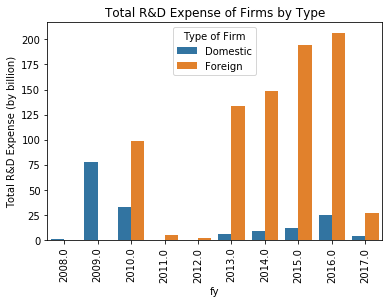

In [162]:
plt.figure().add_subplot(111).set_yticklabels([0,25,50,75,100,125,150,175,200])
sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_sum_comparison)
plt.xticks(rotation='vertical')
plt.ylabel('Total R&D Expense (by billion)')
plt.title('Total R&D Expense of Firms by Type')

Text(0.5,1,'Number of Firms by Type')

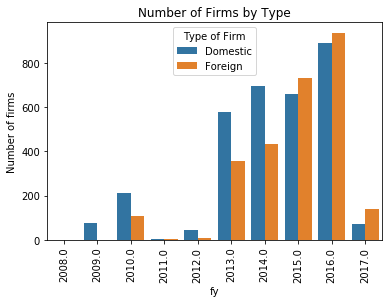

In [163]:
sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_number_of_companies_comparison)
plt.xticks(rotation='vertical')
plt.ylabel('Number of firms')
plt.title('Number of Firms by Type')

## Fixed Comparison - Fixing years(fy 2013-2016) and Binning by Asset Size

### Dividing firms into 4 bins

In [164]:
# Data only from fy 2013 to fy 2016
df_13_16 = df[(df.fy>=2013) & (df.fy<=2016)]

In [165]:
# Drop firms that have at least one missing Asset values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Assets'])))

In [166]:
# Drop firms that have at least one missing R&D values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['ResearchAndDevelopmentExpense'])))

In [167]:
# Filter only the companies that have data for all fy years 2013 - 2016 (4 assets values per cik group)
df_13_16 = df_13_16.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

In [168]:
df_13_16_foreign = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Foreign']
df_13_16_domestic = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Domestic']

As we can see below, the problem is there are some firms that was domestic one year and was multinational for another year (inconsistent). We are going to drop those companies and exclude them from the analysis

In [169]:
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    160
2014.0    163
2015.0    165
2016.0    168
dtype: int64 

 Domestic: fy
2013.0    144
2014.0    141
2015.0    139
2016.0    136
dtype: int64


In [170]:
# Dropping MNCs that have missing UFEs for all years
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: all(pd.notnull(x['UndistributedEarningsOfForeignSubsidiaries'])))

In [171]:
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: x['fy'].nunique()==4)
df_13_16_domestic = df_13_16_domestic.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

In [172]:
# Now we have the same number of multinational firms and domestic firms throughout all years
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    80
2014.0    80
2015.0    80
2016.0    80
dtype: int64 

 Domestic: fy
2013.0    133
2014.0    133
2015.0    133
2016.0    133
dtype: int64


In [173]:
# Make a new dataframe df_13_16 with the modified foreign and domestic firms data
df_13_16= df_13_16_foreign.append(df_13_16_domestic)

We use fy = 2016 and the domestic firms as the base for determining the bin

In [174]:
# # pd.qcut(df_13_16_domestic.copy()[df_13_16_domestic.copy().fy==2016].Assets.tolist(),4,
# #         labels=['0-25%','25-50%','50-75%','75-100%'],retbins=True)

# domestic_fy2016_asset_bin = [ 2.50000000e+04,   3.53300000e+06,   1.09041730e+07, 4.05610000e+07,   5.77700000e+09]

In [175]:
# # Making data with only fy=2016 for classifying firms into bins
# df_16 = df_13_16.copy()[df_13_16.copy().fy==2016]

# # Making the "Bin" column in fy2016 
# df_16['Bin'] =\
# pd.cut(df_16.Assets.tolist(),domestic_fy2016_asset_bin,include_lowest=True,labels=['0-25%','25-50%','50-75%','75-100%'])

In [176]:
# # Dividing CIKs into 4 different bins and storing their firm CIKs
# df_13_16_quart1_cik = df_16.copy()[df_16.copy().Bin=='0-25%'].cik.tolist()
# df_13_16_quart2_cik = df_16.copy()[df_16.copy().Bin=='25-50%'].cik.tolist()
# df_13_16_quart3_cik = df_16.copy()[df_16.copy().Bin=='50-75%'].cik.tolist()
# df_13_16_quart4_cik = df_16.copy()[df_16.copy().Bin=='75-100%'].cik.tolist()

In [177]:
# # Using the above CIKs classified into four bins to partion data into 4 bins
# df_13_16_quart1 = df_13_16.copy()[df_13_16.copy().cik.isin(df_13_16_quart1_cik)]
# df_13_16_quart2 = df_13_16.copy()[df_13_16.copy().cik.isin(df_13_16_quart2_cik)]
# df_13_16_quart3 = df_13_16.copy()[df_13_16.copy().cik.isin(df_13_16_quart3_cik)]
# df_13_16_quart4 = df_13_16.copy()[df_13_16.copy().cik.isin(df_13_16_quart4_cik)]

In [178]:
# #Checking if each bin has equal number of firms throughout years
# df_13_16_quart1.groupby(['fy']).size(), df_13_16_quart2.groupby(['fy']).size(), df_13_16_quart3.groupby(['fy']).size(), \
# df_13_16_quart4.groupby(['fy']).size()

### 0-25% percentile

In [179]:
# # Sum of R & D of firms in bin 0-25% per year by type 
# r_and_d_quart1_mean_comparison =\
# pd.DataFrame(df_13_16_quart1[df_13_16_quart1['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].mean()).reset_index()

In [180]:
# # Sum of R & D of firms in bin 0-25% per year by type 
# r_and_d_quart1_asset_mean_comparison =\
# pd.DataFrame(df_13_16_quart1[df_13_16_quart1['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Assets','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['Assets'].mean()).reset_index()

In [181]:
# # Number of firms in bin 0-25% per year by type
# r_and_d_quart1_count_comparison=\
# pd.DataFrame(df_13_16_quart1[df_13_16_quart1['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### 25-50% percentile

In [182]:
# # Sum of R & D of firms in bin 25-50% per year by type 
# r_and_d_quart2_mean_comparison =\
# pd.DataFrame(df_13_16_quart2[df_13_16_quart2['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].mean()).reset_index()

In [183]:
# # Difference between total R&D of multinational & domestic firms in 25-50% per year
# r_and_d_quart2_mean_diff_comparison = \
# r_and_d_quart2_mean_comparison.groupby('fy')['ResearchAndDevelopmentExpense'].\
# apply(lambda x: (x.iloc[1] - x.iloc[0])*100/ x.iloc[1])

# r_and_d_quart2_mean_diff_comparison = pd.DataFrame(r_and_d_quart2_mean_diff_comparison).reset_index()

In [184]:
# # Sum of R & D of firms in bin 25-50% per year by type 
# r_and_d_quart2_asset_mean_comparison =\
# pd.DataFrame(df_13_16_quart2[df_13_16_quart2['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Assets','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['Assets'].mean()).reset_index()

In [185]:
# # Number of firms in bin 25-50% per year by type
# r_and_d_quart2_count_comparison=\
# pd.DataFrame(df_13_16_quart2[df_13_16_quart2['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### 50-75% percentile

In [186]:
# # Sum of R & D of firms in bin 50-75% per year by type 
# r_and_d_quart3_mean_comparison =\
# pd.DataFrame(df_13_16_quart3[df_13_16_quart3['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].mean()).reset_index()

In [187]:
# # Difference between total R&D of multinational & domestic firms in 50-75% per year
# r_and_d_quart3_mean_diff_comparison = \
# r_and_d_quart3_mean_comparison.groupby('fy')['ResearchAndDevelopmentExpense'].\
# apply(lambda x: (x.iloc[1] - x.iloc[0])*100/ x.iloc[1])

# r_and_d_quart3_mean_diff_comparison = pd.DataFrame(r_and_d_quart3_mean_diff_comparison).reset_index()

In [188]:
# # Sum of R & D of firms in bin 50-75% per year by type 
# r_and_d_quart3_asset_mean_comparison =\
# pd.DataFrame(df_13_16_quart3[df_13_16_quart3['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Assets','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['Assets'].mean()).reset_index()

In [189]:
# # Number of firms in bin 50-75% per year by type
# r_and_d_quart3_count_comparison=\
# pd.DataFrame(df_13_16_quart3[df_13_16_quart3['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### 75-100% percentile

In [190]:
# # Sum of R & D of firms in bin 75-100% per year by type 
# r_and_d_quart4_mean_comparison =\
# pd.DataFrame(df_13_16_quart4[df_13_16_quart4['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].mean()).reset_index()

In [191]:
# # Difference between total R&D of multinational & domestic firms in 75-100% per year
# r_and_d_quart4_mean_diff_comparison = \
# r_and_d_quart4_mean_comparison.groupby('fy')['ResearchAndDevelopmentExpense'].\
# apply(lambda x: (x.iloc[1] - x.iloc[0])*100/ x.iloc[1])

# r_and_d_quart4_mean_diff_comparison = pd.DataFrame(r_and_d_quart4_mean_diff_comparison).reset_index()

In [192]:
# # Sum of R & D of firms in bin 75-100% per year by type 
# r_and_d_quart4_asset_mean_comparison =\
# pd.DataFrame(df_13_16_quart4[df_13_16_quart4['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Assets','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['Assets'].mean()).reset_index()

In [193]:
# # Number of firms in bin 75-100% per year by type
# r_and_d_quart4_count_comparison=\
# pd.DataFrame(df_13_16_quart4[df_13_16_quart4['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Visualizations

In [194]:
# # Mean of R&D Expense for MNC and domestic firms throughout years

# f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(12,10))

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart1_mean_comparison,ax=ax1)
# ax1.set_yticklabels([0,100,200,300,400,500,600,700])
# ax1.set_ylabel('Mean R&D Expense (by thousands)')
# ax1.set_title('Mean R&D Expense of Firms (0-25%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart2_mean_comparison,ax=ax2)
# ax2.set_yticklabels([0,1,2,3,4,5,6])
# ax2.set_ylabel('Mean R&D Expense (by millions)')
# ax2.set_title('Mean R&D Expense of Firms (25-50%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart3_mean_comparison,ax=ax3)
# ax3.set_yticklabels([0,1,2,3,4,5])
# ax3.set_ylabel('Mean R&D Expense (by millions)')
# ax3.set_title('Mean R&D Expense of Firms (50-75%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart4_mean_comparison,ax=ax4)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax4.set_ylabel('Mean R&D Expense (by millions)')
# ax4.set_title('Mean R&D Expense of Firms (75-100%)')

# plt.tight_layout()

In [195]:
# # Percentage Difference in mean R&D Expense for MNC and domestic firms throughout years (MNC - domestic / MNC)

# f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(16,8))

# # sns.pointplot(x='fy',y='ResearchAndDevelopmentExpense',data= r_and_d_quart1_mean_diff_comparison,ax=ax1)
# # ax1.set_ylabel('Mean R&D Expense')
# # ax1.set_title('Mean R&D Expense of Firms (0-25%)')

# sns.pointplot(x='fy',y='ResearchAndDevelopmentExpense',data= r_and_d_quart2_mean_diff_comparison,ax=ax2)
# ax2.set_ylabel('Difference of mean R&D expense')
# ax2.set_title('Difference of mean R&D expense (MNC - Domestic Firms / MNC) (25-50%)')

# sns.pointplot(x='fy',y='ResearchAndDevelopmentExpense',data= r_and_d_quart3_mean_diff_comparison,ax=ax3)
# ax3.set_ylabel('Difference of mean R&D expense')
# ax3.set_title('Difference of mean R&D expense (MNC - Domestic Firms / MNC) (50-75%)')

# sns.pointplot(x='fy',y='ResearchAndDevelopmentExpense',data= r_and_d_quart4_mean_diff_comparison,ax=ax4)
# ax4.set_ylabel('Difference of mean R&D expense')
# ax4.set_title('Difference of mean R&D expense (MNC - Domestic Firms / MNC) (75-100%)')

# plt.tight_layout()

In [196]:
# f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(10,10))

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart1_count_comparison, ax=ax1)
# ax1.set_ylabel('Number of firms')
# ax1.set_title('Number of Firms (0-25%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart2_count_comparison, ax=ax2)
# ax2.set_ylabel('Number of firms')
# ax2.set_title('Number of Firms (25-50%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart3_count_comparison, ax=ax3)
# ax3.set_ylabel('Number of firms')
# ax3.set_title('Number of Firms (50-75%)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart4_count_comparison, ax=ax4)
# ax4.set_ylabel('Number of firms')
# ax4.set_title('Number of Firms (75-100%)')

In [197]:
# f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(10,10))

# sns.barplot(x='fy',y='Assets',hue='Type of Firm',data= r_and_d_quart1_asset_mean_comparison,ax=ax1)
# ax1.set_ylabel('Mean Asset')
# ax1.set_title('Mean Asset of Firms (0-25%)')

# sns.barplot(x='fy',y='Assets',hue='Type of Firm',data= r_and_d_quart2_asset_mean_comparison,ax=ax2)
# ax2.set_ylabel('Mean Asset')
# ax2.set_title('Mean Asset of Firms (25-50%)')

# sns.barplot(x='fy',y='Assets',hue='Type of Firm',data= r_and_d_quart3_asset_mean_comparison,ax=ax3)
# ax3.set_ylabel('Mean Asset')
# ax3.set_title('Mean Asset of Firms (50-75%)')

# sns.barplot(x='fy',y='Assets',hue='Type of Firm',data= r_and_d_quart4_asset_mean_comparison,ax=ax4)
# ax4.set_ylabel('Mean Asset')
# ax4.set_title('Mean Asset of Firms (75-100%)')

# plt.tight_layout()

## Comparison by Industry

- Industry1: 'Mining and Construction'
- Industry2: 'Manufacturing'
- Industry3: 'Transportation, Communication, Electric, Gas'
- Industry4: 'Wholesale, Retail'
- Industry5: 'Financial, Insurance, Real Estate'
- Industry6: 'Services'
- Industry7: 'Public Administration'

In [198]:
# Dividing data into 7 different industries

r_and_d_industry1 = df_13_16.copy()[df_13_16.copy().industry=='Mining and Construction']
r_and_d_industry2 = df_13_16.copy()[df_13_16.copy().industry=='Manufacturing']
r_and_d_industry3 = df_13_16.copy()[df_13_16.copy().industry=='Transportation, Communication, Electric, Gas']
r_and_d_industry4 = df_13_16.copy()[df_13_16.copy().industry=='Wholesale, Retail']
r_and_d_industry5 = df_13_16.copy()[df_13_16.copy().industry=='Financial, Insurance, Real Estate']
r_and_d_industry6 = df_13_16.copy()[df_13_16.copy().industry=='Services']
r_and_d_industry7 = df_13_16.copy()[df_13_16.copy().industry=='Public Administration']

In [199]:
# Storing MNCs and Domestic Firms in Manufacturing in variables

manuf_mnc = r_and_d_industry2[r_and_d_industry2['Type of Firm']=='Foreign']
manuf_domest = r_and_d_industry2[r_and_d_industry2['Type of Firm']=='Domestic']

In [200]:
# # Saving MNCs and Domestic Firms in Manufacturing into csv files for future use
# manuf_mnc.to_csv('manuf_mnc.csv')
# manuf_domest.to_csv('manuf_domest.csv')

In [201]:
# # Number of firms in bin 0-25% for different industries
# r_and_d_quart1_industry_count_comparison=\
# pd.DataFrame(df_13_16_quart1[df_13_16_quart1['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','industry','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['industry','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

In [202]:
# # Number of firms in bin 25-50% for different industries
# r_and_d_quart2_industry_count_comparison=\
# pd.DataFrame(df_13_16_quart2[df_13_16_quart2['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','industry','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['industry','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

In [203]:
# # Number of firms in bin 50-75% for different industries
# r_and_d_quart3_industry_count_comparison=\
# pd.DataFrame(df_13_16_quart3[df_13_16_quart3['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','industry','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['industry','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

In [204]:
# # Number of firms in bin 75-100% for different industries
# r_and_d_quart4_industry_count_comparison=\
# pd.DataFrame(df_13_16_quart4[df_13_16_quart4['ResearchAndDevelopmentExpense'].notnull()].\
#              loc[:,['cik','industry','Type of Firm','ResearchAndDevelopmentExpense']].\
#              groupby(['industry','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Industry 1: Mining and Construction

In [205]:
# Count of firms in industry 1
r_and_d_industry1_count =\
pd.DataFrame(r_and_d_industry1[r_and_d_industry1['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

In [206]:
# Mean of (R & D / Assets) of firms in industry1 per year
r_and_d_industry1_mean_scaled =\
pd.DataFrame(r_and_d_industry1[r_and_d_industry1['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [207]:
# Difference of scaled mean between domestic firms and MNCs (Mining and Construction)
r_and_d_industry1_mean_diff = \
r_and_d_industry1_mean_scaled.groupby('fy')['ResearchAndDevelopmentExpense_scaled'].\
apply(lambda x: x.iloc[0] - x.iloc[1])

r_and_d_industry1_mean_diff = pd.DataFrame(r_and_d_industry1_mean_diff).reset_index()

### Industry 2: Manufacturing

In [208]:
# Mean of (R & D / Assets) of firms in industry 2 per year
r_and_d_industry2_mean_scaled =\
pd.DataFrame(r_and_d_industry2[r_and_d_industry2['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [209]:
# Count of firms in industry 2
r_and_d_industry2_count =\
pd.DataFrame(r_and_d_industry2[r_and_d_industry2['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

In [210]:
# Difference of scaled mean between domestic firms and MNCs (Manufacturing)
r_and_d_industry2_mean_diff = \
r_and_d_industry2_mean_scaled.groupby('fy')['ResearchAndDevelopmentExpense_scaled'].\
apply(lambda x: x.iloc[1] - x.iloc[0])

r_and_d_industry2_mean_diff = pd.DataFrame(r_and_d_industry2_mean_diff).reset_index()

### Industry 3: Transportation, Communication, Electric, Gas

In [211]:
# Mean of (R & D / Assets) of firms in industry3 per year
r_and_d_industry3_mean_scaled =\
pd.DataFrame(r_and_d_industry3[r_and_d_industry3['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [212]:
# Count of firms in industry 3
r_and_d_industry3_count =\
pd.DataFrame(r_and_d_industry3[r_and_d_industry3['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Industry 4: Wholesale, Retail

In [213]:
# Mean of (R & D / Assets) of firms in industry4 per year
r_and_d_industry4_mean_scaled =\
pd.DataFrame(r_and_d_industry4[r_and_d_industry4['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [214]:
# Count of firms in industry 4
r_and_d_industry4_count =\
pd.DataFrame(r_and_d_industry4[r_and_d_industry4['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Industry 4: Wholesale, Retail

### Industry 5: Financial, Insurance, Real Estate

In [215]:
# Mean of (R & D / Assets) of firms in industry 5 per year
r_and_d_industry5_mean_scaled =\
pd.DataFrame(r_and_d_industry5[r_and_d_industry5['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [216]:
# Count of firms in industry 5
r_and_d_industry5_count =\
pd.DataFrame(r_and_d_industry5[r_and_d_industry5['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Industry 6: Services

In [217]:
# Mean of (R & D / Assets) of firms in industry 5 per year
r_and_d_industry6_mean_scaled =\
pd.DataFrame(r_and_d_industry6[r_and_d_industry6['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [218]:
# Count of firms in industry 6
r_and_d_industry6_count =\
pd.DataFrame(r_and_d_industry6[r_and_d_industry6['ResearchAndDevelopmentExpense'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense'].count()).reset_index()

### Industry 7: Public Administration

In [219]:
# Mean of (R & D / Assets) of firms in industry 7 per year
r_and_d_industry7_mean_scaled =\
pd.DataFrame(r_and_d_industry7[r_and_d_industry7['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

In [220]:
r_and_d_industry7_mean_scaled

,fy,Type of Firm,ResearchAndDevelopmentExpense_scaled


### Visualizations

In [221]:
# # Count of firms in quartile bins for different industries
# f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(20,10))

# sns.barplot(y='industry',x='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart1_industry_count_comparison, ax=ax1)
# ax1.set_ylabel('Number of firms')
# ax1.set_title('Number of Firms (0-25%)')

# sns.barplot(y='industry',x='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart2_industry_count_comparison, ax=ax2)
# ax2.set_ylabel('Number of firms')
# ax2.set_title('Number of Firms (25-50%)')

# sns.barplot(y='industry',x='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart3_industry_count_comparison, ax=ax3)
# ax3.set_ylabel('Number of firms')
# ax3.set_title('Number of Firms (50-75%)')

# sns.barplot(y='industry',x='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_quart4_industry_count_comparison, ax=ax4)
# ax4.set_ylabel('Number of firms')
# ax4.set_title('Number of Firms (75-100%)')

# plt.tight_layout()

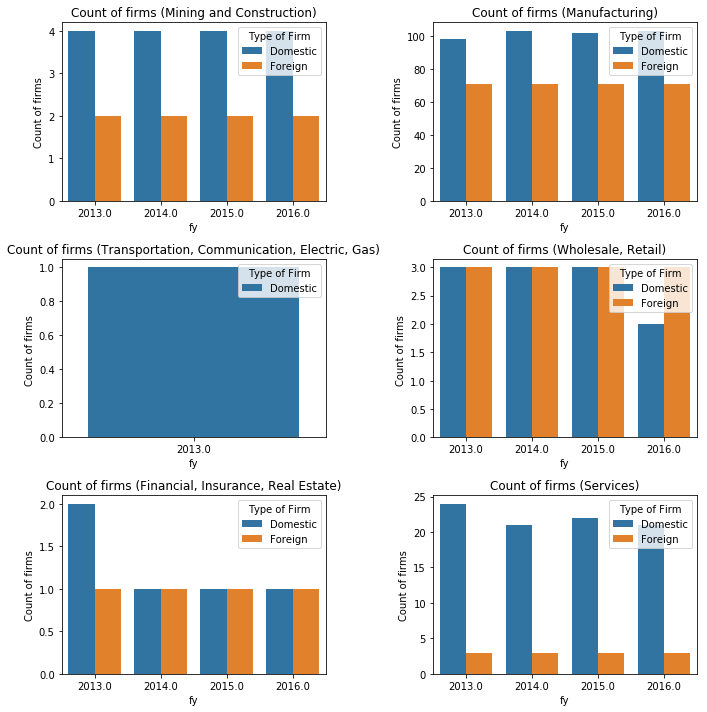

In [222]:
# Mean of (R&D / Assets) for MNC and domestic firms throughout years for different industries

f, ((ax1, ax2), (ax3, ax4),(ax5,ax6))= plt.subplots(3,2, figsize=(10,10))

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry1_count,ax=ax1)
# ax1.set_yticklabels([0,100,200,300,400,500,600,700])
ax1.set_ylabel('Count of firms')
ax1.set_title('Count of firms (Mining and Construction)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry2_count,ax=ax2)
# ax2.set_yticklabels([0,1,2,3,4,5,6])
ax2.set_ylabel('Count of firms')
ax2.set_title('Count of firms (Manufacturing)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry3_count,ax=ax3)
# ax3.set_yticklabels([0,1,2,3,4,5])
ax3.set_ylabel('Count of firms ')
ax3.set_title('Count of firms (Transportation, Communication, Electric, Gas)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry4_count,ax=ax4)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax4.set_ylabel('Count of firms ')
ax4.set_title('Count of firms (Wholesale, Retail)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry5_count,ax=ax5)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax5.set_ylabel('Count of firms')
ax5.set_title('Count of firms (Financial, Insurance, Real Estate)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense',hue='Type of Firm',data= r_and_d_industry6_count,ax=ax6)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax6.set_ylabel('Count of firms')
ax6.set_title('Count of firms (Services)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry7_mean_scaled,ax=ax7)
# # ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax7.set_ylabel('Mean R&D Expense scaled with Assets (by millions)')
# ax7.set_title('Mean R&D Expense scaled with Assets (Public Administration)')

plt.tight_layout()

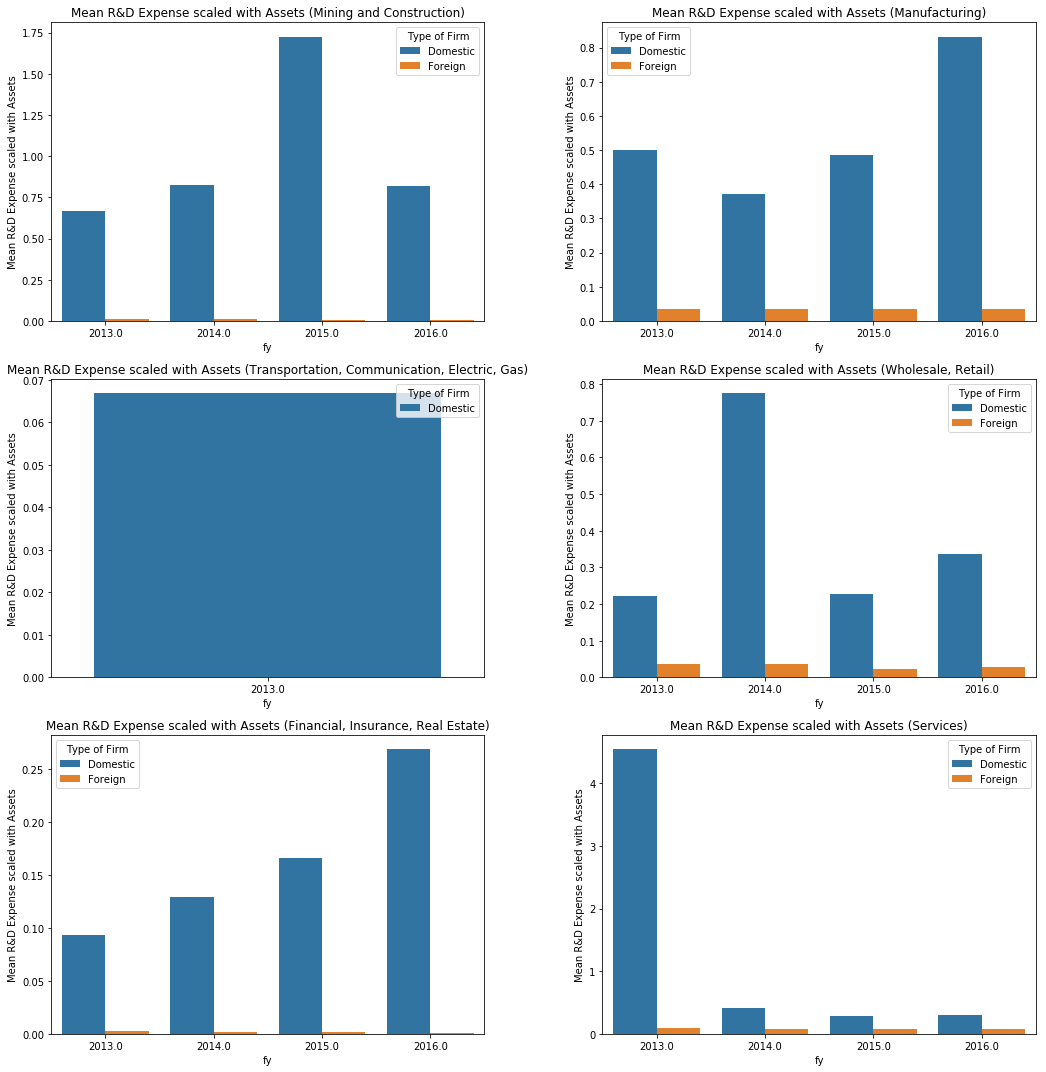

In [223]:
# Mean of (R&D / Assets) for MNC and domestic firms throughout years for different industries

f, ((ax1, ax2), (ax3, ax4),(ax5,ax6))= plt.subplots(3,2, figsize=(15,15))

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry1_mean_scaled,ax=ax1)
# ax1.set_yticklabels([0,100,200,300,400,500,600,700])
ax1.set_ylabel('Mean R&D Expense scaled with Assets')
ax1.set_title('Mean R&D Expense scaled with Assets (Mining and Construction)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry2_mean_scaled,ax=ax2)
# ax2.set_yticklabels([0,1,2,3,4,5,6])
ax2.set_ylabel('Mean R&D Expense scaled with Assets')
ax2.set_title('Mean R&D Expense scaled with Assets (Manufacturing)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry3_mean_scaled,ax=ax3)
# ax3.set_yticklabels([0,1,2,3,4,5])
ax3.set_ylabel('Mean R&D Expense scaled with Assets')
ax3.set_title('Mean R&D Expense scaled with Assets (Transportation, Communication, Electric, Gas)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry4_mean_scaled,ax=ax4)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax4.set_ylabel('Mean R&D Expense scaled with Assets')
ax4.set_title('Mean R&D Expense scaled with Assets (Wholesale, Retail)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry5_mean_scaled,ax=ax5)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax5.set_ylabel('Mean R&D Expense scaled with Assets')
ax5.set_title('Mean R&D Expense scaled with Assets (Financial, Insurance, Real Estate)')

sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry6_mean_scaled,ax=ax6)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax6.set_ylabel('Mean R&D Expense scaled with Assets')
ax6.set_title('Mean R&D Expense scaled with Assets (Services)')

# sns.barplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm',data= r_and_d_industry7_mean_scaled,ax=ax7)
# # ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax7.set_ylabel('Mean R&D Expense scaled with Assets (by millions)')
# ax7.set_title('Mean R&D Expense scaled with Assets (Public Administration)')

plt.tight_layout()

Industry 2 (Manufacturing) is the only industry that we have some data points to analyze with (246 observations), so we will be focusing on the manufacturing industry and will also plot the undistributed foreign earnings normalized by Assets below to see if the trend supports our hypothesis

Text(0,0.5,'Mean R&D Expense normalized')

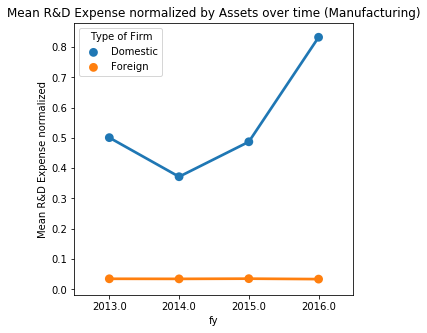

In [224]:
# Mean R&D Expense normalized by Assets over time
plt.subplots(figsize=(5,5))
sns.pointplot(x='fy', y='ResearchAndDevelopmentExpense_scaled', 
              hue='Type of Firm', data=r_and_d_industry2_mean_scaled)

plt.title('Mean R&D Expense normalized by Assets over time (Manufacturing)')
plt.ylabel('Mean R&D Expense normalized')

Text(0,0.5,'Mean R&D Expense normalized')

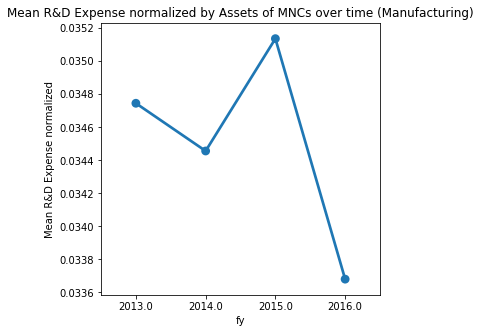

In [225]:
# Mean R&D Expense normalized by Assets of MNCs over time
plt.subplots(figsize=(5,5))
sns.pointplot(x='fy', y='ResearchAndDevelopmentExpense_scaled',
              data=r_and_d_industry2_mean_scaled[r_and_d_industry2_mean_scaled['Type of Firm']=='Foreign'])

plt.title('Mean R&D Expense normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean R&D Expense normalized')

Text(0.5,1,'Difference in Mean of normalized R&D Expense for Manufacturing Industry (MNCs - Domestic Firms)')

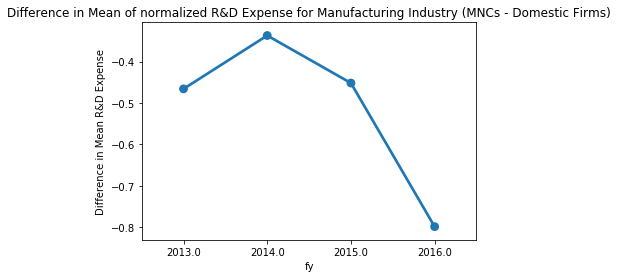

In [226]:
# Manufacturing industry : difference in Mean R&D  (MNCs - domestic firms) 

sns.pointplot(x='fy',y='ResearchAndDevelopmentExpense_scaled',data= r_and_d_industry2_mean_diff)
plt.ylabel('Difference in Mean R&D Expense')
plt.title('Difference in Mean of normalized R&D Expense for Manufacturing Industry (MNCs - Domestic Firms)')

In [227]:
r_and_d_industry2['UndistributedEarningsOfForeignSubsidiaries_scaled']=\
r_and_d_industry2['UndistributedEarningsOfForeignSubsidiaries']/r_and_d_industry2['Assets']

Text(0.5,1,'Mean Undistributed Foreign Earnings normalized (Manufacturing)')

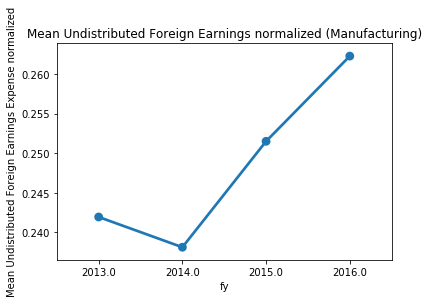

In [228]:
# Normalized Mean Undistributed Foreign Earnings of Manufacturing Industry
sns.pointplot(x='fy',y='UndistributedEarningsOfForeignSubsidiaries_scaled',
              data= pd.DataFrame(r_and_d_industry2[r_and_d_industry2['Type of Firm']=='Foreign'].\
             groupby(['fy'])['UndistributedEarningsOfForeignSubsidiaries_scaled'].mean()).reset_index())
plt.ylabel('Mean Undistributed Foreign Earnings Expense normalized')
plt.title('Mean Undistributed Foreign Earnings normalized (Manufacturing)')

In [229]:
r_and_d_industry2.groupby(['Type of Firm','fy']).size()

Type of Firm  fy    
Domestic      2013.0     98
              2014.0    103
              2015.0    102
              2016.0    103
Foreign       2013.0     71
              2014.0     71
              2015.0     71
              2016.0     71
dtype: int64